[ 0.00000000e+00  0.00000000e+00 -9.94353643e-05 -9.42334779e-05]
[ 0.00000000e+00  0.00000000e+00 -9.94353643e-05 -9.42334779e-05]
Same gradients
(63000, 784)
(63000, 10)
Epoch 1, Loss: 2.637
Epoch 2, Loss: 1.609
Epoch 3, Loss: 1.056
Epoch 4, Loss: 0.937
Epoch 5, Loss: 0.871
Epoch 6, Loss: 1.011
Epoch 7, Loss: 0.766
Epoch 8, Loss: 0.734
Epoch 9, Loss: 0.790
Epoch 10, Loss: 0.670
Epoch 11, Loss: 0.654
Epoch 12, Loss: 0.587
Epoch 13, Loss: 0.572
Epoch 14, Loss: 0.669
Epoch 15, Loss: 0.567


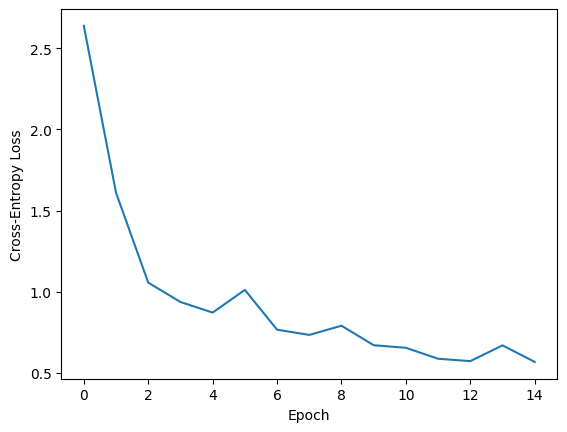

Final Train Accuracy: 0.8448
Final Test Accuracy: 0.8336


c:\Users\rotki\GitHub\FYS-STK\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Scikit-learn Model Accuracy: 0.9209


c:\Users\rotki\GitHub\FYS-STK\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [20]:
#TEST

import autograd.numpy as np  
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Defining some activation functions and their derivative
def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))

def mse(predict, target):
    return np.mean((predict - target) ** 2)

def mse_der(predict, target):
    return 2 * (predict - target) / np.prod(predict.shape)

def softmax(z):
    """Compute softmax values for each set of scores in the rows of the matrix z.
    Used with batched input data."""
    e_z = np.exp(z - np.max(z, axis=1)[:, np.newaxis]) #substract max per row, avoids instability
    return e_z / np.sum(e_z, axis=1)[:, np.newaxis]

def softmax_vec(z):
    """Compute softmax values for each set of scores in the vector z.
    Use this function when you use the activation function on one vector at a time"""
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z)

def softmax_der(z):
    return np.ones_like(z) 
#Purely placeholder, combined derivative 
#Cross entropy + softmax simplifies to predict-target

def cross_entropy(predict, target):
    return np.mean(-np.sum(target * np.log(predict + 1e-10), axis=1))

def cross_entropy_der(predict, target):
    return (predict - target) / predict.shape[0]


#Initializing creation of n layers for batched input shapes
def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        W = W.T
        b = np.random.randn(layer_output_size)
        layers.append((W, b))

        i_size = layer_output_size
    return layers

#Applying weights, bias and activation function and passing forward
def feed_forward_saver_batch(input, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b
        a = activation_func(z)

        zs.append(z)

    return layer_inputs, zs, a

#Same, but when saving layer_inputs and zs is not needed
def feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = a @ W + b
        a = activation_func(z)
    return a

#Verify gradients
def cost(input, layers, activation_funcs, target):
    predict = feed_forward_saver_batch(input, layers, activation_funcs)[2]
    return mse(predict, target)

#Computing gradients
def backpropagation_batch(
    input, layers, activation_funcs, target, activation_ders, cost_der=mse_der
):
    layer_inputs, zs, predict = feed_forward_saver_batch(input, layers, activation_funcs)

    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict, target)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = dC_dz @ W.T

        dC_dz = dC_da * activation_der(z)
        dC_dW = layer_input.T @ dC_dz  #W gradients for batches
        dC_db = np.sum(dC_dz, axis=0)   #sum bias gradients, batch dim

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

### For gradient verification with autograd
network_input_size = 4
batch_size = 400
layer_output_sizes = [3, 4]
activation_funcs = [sigmoid, ReLU]
activation_ders = [sigmoid_der, ReLU_der]
la = create_layers_batch(network_input_size, layer_output_sizes)

x = np.random.randn(batch_size, network_input_size)
input = x
target = np.random.rand(4)

computed = backpropagation_batch(input, la, activation_funcs, target, activation_ders)
print(computed[-1][0][0])

cost_grad = grad(cost, 1)
autoG = cost_grad(input, la, activation_funcs, target)
print(autoG[-1][0][0])

diff = 0
for i in range(len(computed)):
    diff += abs(computed[-1][0][0][i])-abs(autoG[-1][0][0][i])
if diff <= 10**-6:
    print("Same gradients")
###

#Applying FFNN base above to classification problem, MNIST:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

#Extract data (features) and target (labels)
X = mnist.data
y_labels = mnist.target.astype(int)
X = X / 255.0

#print(y_labels)
#One-hot encode labels
y = np.eye(10)[y_labels] #Convert to integers

#Split into train and test
#y_train_labels and y_test_labels for scikit-learn, expects integer labels
X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    X, y, y_labels, test_size=0.1, random_state=42
)

print(X_train.shape)
print(y_train.shape)

def accuracy(predictions, targets):
    one_hot_predictions = np.zeros(predictions.shape)
    for i, prediction in enumerate(predictions):
        one_hot_predictions[i, np.argmax(prediction)] = 1
    return accuracy_score(one_hot_predictions, targets)

def train_network(X_train, y_train, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size=64):
    losses = []
    for epoch in range(epochs):
        # Shuffle digits, avoids learning misleading patterns. Independent data
        perm = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[perm] 
        y_shuffled = y_train[perm]
        
        # Mini-batch loop
        for start in range(0, X_train.shape[0], batch_size):
            end = start + batch_size
            input_batch = X_shuffled[start:end] #batches change each epoch, fresh shuffle
            target_batch = y_shuffled[start:end] #Keeping input and target labels aligned
            
            layers_grad = backpropagation_batch(input_batch, layers, activation_funcs, target_batch, activation_ders, cost_der=cross_entropy_der)
            for (W, b), (W_g, b_g) in zip(layers, layers_grad):
                W -= learning_rate * W_g
                b -= learning_rate * b_g
        
        # Compute loss after epoch
        predictions = feed_forward(X_train, layers, activation_funcs)
        loss = cross_entropy(predictions, y_train)
        losses.append(loss)
        print(f"Epoch {epoch+1}, Loss: {loss:.3f}")
    
    return layers, losses, predictions
"""
#Set parameters for network (easily changable)
network_input_size = 784
layer_output_sizes = [128, 10]  # One hidden layer with 128 neurons, output 10 classes
activation_funcs = [ReLU, softmax]
activation_ders = [ReLU_der, softmax_der]
"""
network_input_size = 784
layer_output_sizes = [256, 128, 10]  # One hidden layer with 128 neurons, output 10 classes
activation_funcs = [ ReLU, ReLU, softmax]
activation_ders = [ReLU_der, ReLU_der, softmax_der]

#Create layers
layers = create_layers_batch(network_input_size, layer_output_sizes)

#Train
epochs = 15
learning_rate = 0.01
batch_size = 64
trained_layers, losses, train_predictions = train_network(X_train, y_train, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size)

#Plot loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.show()

#Accuracy
train_acc = accuracy(train_predictions, y_train)
print(f"Final Train Accuracy: {train_acc:.4f}")

#Test accuracy
test_predictions = feed_forward(X_test, trained_layers, activation_funcs)
test_acc = accuracy(test_predictions, y_test)
print(f"Final Test Accuracy: {test_acc:.4f}")

#Scikit-learn Logistic Regression comparison
model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10, random_state=42)
model.fit(X_train, y_train_labels)
y_pred = model.predict(X_test)
sk_accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Scikit-learn Model Accuracy: {sk_accuracy:.4f}")